In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from matplotlib import pyplot as plt

In [2]:

# --- Load CSV from Google Drive ---
def load_gdrive_csv(view_url):
    file_id = view_url.split('/')[-2]
    url = f'https://drive.google.com/uc?id={file_id}'
    return pd.read_csv(url, on_bad_lines='skip')

train_df = load_gdrive_csv('https://drive.google.com/file/d/12ldtQDa9HMKy9z4WGBNd2u_JM_YFGi61/view?usp=drive_link')
test_df = load_gdrive_csv('https://drive.google.com/file/d/1r0IyuFNJ1AAYGrC3bVOqVNKpUqCcMPuJ/view?usp=drive_link')

In [3]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

In [4]:
features = ['Price', 'Open', 'High', 'Low', 'Change %']
target_col = 'Price'
target_index = features.index(target_col)

In [5]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

In [6]:
# --- Create sequences for single-step forecasting ---
window_size = 60
forecast_horizon = 1  # chỉ dự báo 1 bước tiếp theo

def create_sequences(data, window_size, target_index):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_index])  # chỉ lấy 1 giá trị
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, window_size, target_index)
X_test, y_test = create_sequences(test_scaled, window_size, target_index)

print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Testing shape: {X_test.shape}, {y_test.shape}")

Training shape: (3104, 60, 5), (3104,)
Testing shape: (732, 60, 5), (732,)


In [7]:
# --- Positional Encoding ---
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


In [8]:
# --- Transformer Block ---
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

In [9]:
def build_transformer_model(input_shape, embed_dim, num_heads, ff_dim, dropout_rate, learning_rate):
    seq_len, num_features = input_shape

    inputs = Input(shape=(seq_len, num_features))
    x = tf.keras.layers.Dense(embed_dim)(inputs)  # Embedding projection to embed_dim

    # Add positional encoding
    pos_encoding = get_positional_encoding(seq_len, embed_dim)
    x = x + pos_encoding[:, :seq_len, :]

    x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(forecast_horizon)(x)  # chỉ dự báo 1 bước (forecast_horizon=1)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')
    return model

In [10]:
# --- Evaluation ---
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, mape, r2

In [11]:
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

In [12]:
param_grid = {
    'embed_dim': [64],
    'num_heads': [4],
    'ff_dim': [64, 128],
    'dropout_rate': [0.1, 0.2],
    'learning_rate': [0.001, 0.005],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}



best_val_loss = np.inf
best_model = None
best_params = None

for params in ParameterGrid(param_grid):
    print(f"\nTraining with params: {params}")
    model = build_transformer_model(
        input_shape=(window_size, len(features)),
        embed_dim=params['embed_dim'],
        num_heads=params['num_heads'],
        ff_dim=params['ff_dim'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    history = model.fit(
        X_train_sub, y_train_sub,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    val_loss = min(history.history['val_loss'])
    print(f" → Validation loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = params

print(f"\nBest params: {best_params}")
print(f"Best validation loss: {best_val_loss:.6f}")


Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'embed_dim': 64, 'epochs': 50, 'ff_dim': 64, 'learning_rate': 0.001, 'num_heads': 4}
 → Validation loss: 0.000063

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'embed_dim': 64, 'epochs': 50, 'ff_dim': 64, 'learning_rate': 0.005, 'num_heads': 4}
 → Validation loss: 0.000242

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'embed_dim': 64, 'epochs': 50, 'ff_dim': 128, 'learning_rate': 0.001, 'num_heads': 4}
 → Validation loss: 0.000091

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'embed_dim': 64, 'epochs': 50, 'ff_dim': 128, 'learning_rate': 0.005, 'num_heads': 4}
 → Validation loss: 0.000100

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'embed_dim': 64, 'epochs': 100, 'ff_dim': 64, 'learning_rate': 0.001, 'num_heads': 4}
 → Validation loss: 0.000081

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'embed_dim': 64, 'epochs': 100, 'ff_dim': 64, 'le

In [13]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 60, 64)         │        74,944 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,181 (883.52 KB)

 Trainable params: 75,393 (294.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 150,788 (589.02 KB)

In [14]:
# --- Tạo dữ liệu test mới kết hợp 60 ngày cuối train + toàn bộ test_df ---
last_60_train = train_df[features].iloc[-window_size:]
combined_test_input = pd.concat([last_60_train, test_df[features]], axis=0)
combined_scaled = scaler.transform(combined_test_input)

# Tạo các sequences cho test dựa trên dữ liệu kết hợp (chỉ dự báo 1 bước tiếp theo)
X_test_final, y_test_final = create_sequences(combined_scaled, window_size, target_index)

print(f"X_test_final shape: {X_test_final.shape}")
print(f"y_test_final shape: {y_test_final.shape}")

# --- Dự báo ---
y_pred = best_model.predict(X_test_final)  # Output shape (num_samples, 1)
y_pred = y_pred.squeeze()                   # Chuyển thành (num_samples,)

print(f"y_pred shape after squeeze: {y_pred.shape}")

# --- Hàm inverse scale ---
def inverse_transform_single_column(preds, target_index, scaler, feature_len):
    dummy = np.zeros((len(preds), feature_len))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# --- Scale ngược (inverse transform) ---
y_test_inv = inverse_transform_single_column(y_test_final, target_index, scaler, len(features))
y_pred_inv = inverse_transform_single_column(y_pred, target_index, scaler, len(features))

print(f"Shapes after inverse scaling: y_test_inv {y_test_inv.shape}, y_pred_inv {y_pred_inv.shape}")

# --- Đánh giá ---
mae, mse, rmse, mape, r2 = evaluate(y_test_inv, y_pred_inv)

print("\n--- Test Evaluation ---")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")


X_test_final shape: (792, 60, 5)
y_test_final shape: (792,)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
y_pred shape after squeeze: (792,)
Shapes after inverse scaling: y_test_inv (792,), y_pred_inv (792,)

--- Test Evaluation ---
MAE:  4.1630
MSE:  22.6390
RMSE: 4.7580
MAPE: 2.83%
R²:   0.7799


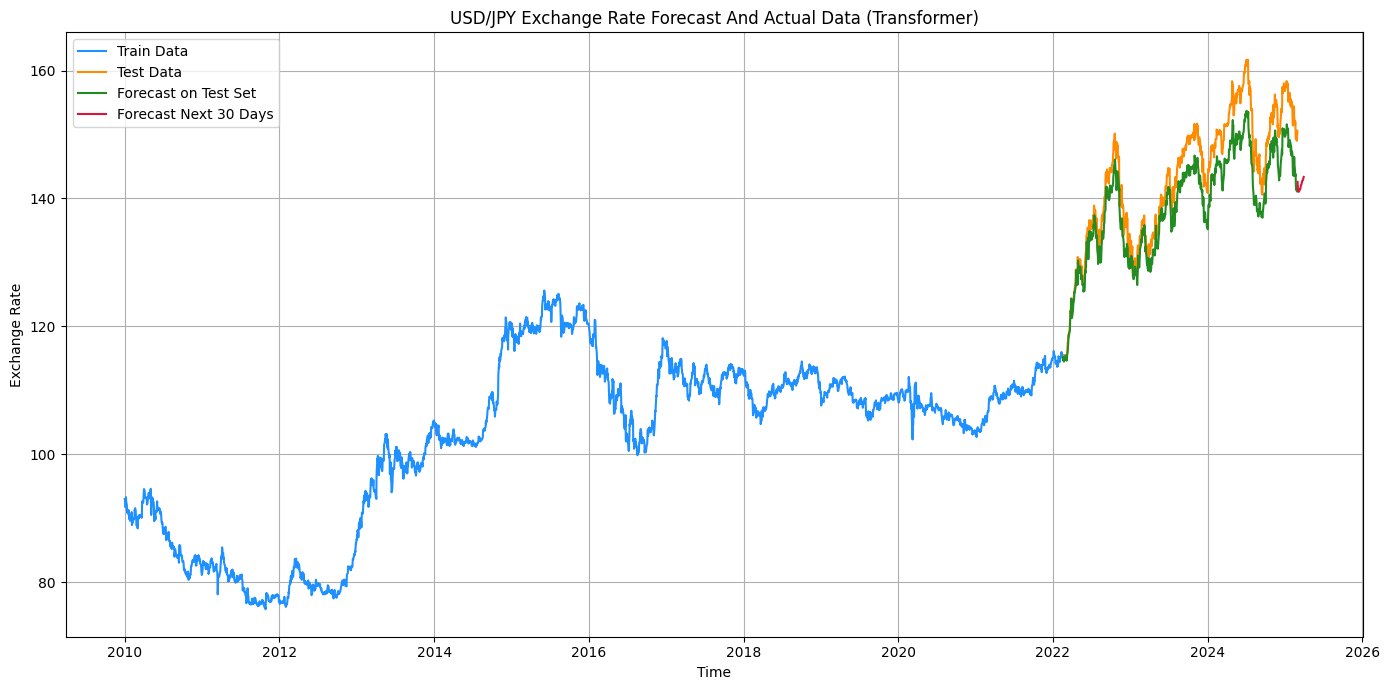

In [15]:
# --- Dự báo 30 ngày tương lai ---
last_60_days = test_df[features].iloc[-window_size:].copy()
last_60_scaled = scaler.transform(last_60_days)

forecast_input = last_60_scaled.copy()
forecast_predictions = []

for _ in range(30):
    input_seq = forecast_input[-window_size:].reshape(1, window_size, len(features))
    next_pred_scaled = best_model.predict(input_seq, verbose=0)[0, 0]

    last_known_row = forecast_input[-1].copy()
    last_known_row[target_index] = next_pred_scaled
    forecast_input = np.vstack([forecast_input, last_known_row])

    forecast_predictions.append(next_pred_scaled)

# --- Hàm inverse scale ---
def inverse_transform_single_column(preds, target_index, scaler, feature_len):
    dummy = np.zeros((len(preds), feature_len))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

forecast_predictions = np.array(forecast_predictions)
forecast_inv = inverse_transform_single_column(forecast_predictions, target_index, scaler, len(features))

# --- Tạo index ngày tương lai ---
last_date = test_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# --- Vẽ tổng hợp ---
plt.figure(figsize=(14, 7))
plt.plot(train_df.index, train_df['Price'], label='Train Data', color='dodgerblue')
plt.plot(test_df.index, test_df['Price'], label='Test Data', color='darkorange')
plt.plot(test_df.index, y_pred_inv, label='Forecast on Test Set', color='forestgreen')
plt.plot(future_dates, forecast_inv, label='Forecast Next 30 Days', color='crimson')

plt.title('USD/JPY Exchange Rate Forecast And Actual Data (Transformer)')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


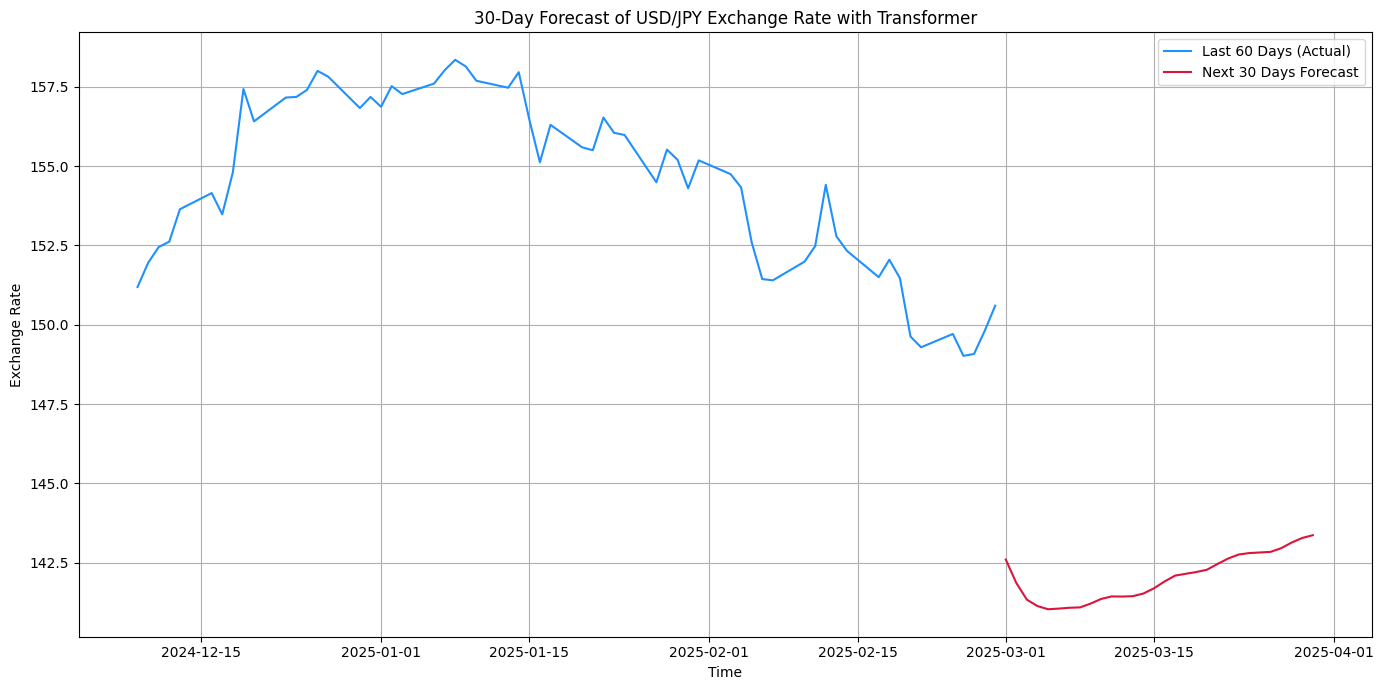

In [16]:
# --- Zoom biểu đồ ---
last_60_actual = test_df['Price'].values[-60:]
last_60_dates = test_df.index[-60:]

plt.figure(figsize=(14, 7))
plt.plot(last_60_dates, last_60_actual, label='Last 60 Days (Actual)', color='dodgerblue')
plt.plot(future_dates, forecast_inv, label='Next 30 Days Forecast', color='crimson')

plt.title('30-Day Forecast of USD/JPY Exchange Rate with Transformer')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
